In [1]:
import zipfile
from collections import Counter
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import os
import numpy as np
import json
import pandas as pd
import shutil
import glob
warnings.filterwarnings("ignore")

#zip_path = 'D:/flame/scripts/data/HumanML3D/texts.zip'

## 1. Text Distribution Check

In [2]:
# 단어의 빈도수를 저장할 Counter 객체 생성
word_counter = Counter()

In [3]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        # .txt 파일만 처리
        if not file_name.endswith('.txt'):
            continue
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        # 파일 내 라인별 처리
        for line in text.splitlines():
            parts = line.strip().split('#')
            if len(parts) < 2:
                continue
            tokens_info = parts[1].split()
            for token in tokens_info:
                if '/' not in token:
                    continue
                word, pos = token.rsplit('/', 1)
                # VERB 태그인 경우에만 카운트
                if pos == 'VERB':
                    word_counter[word] += 1

In [4]:
# 상위 20개 동사 추출
top_verbs = word_counter.most_common(50)

# 결과 출력
print("상위 20개 동사 분포:")
for verb, cnt in top_verbs:
    print(f"{verb}: {cnt}")

상위 20개 동사 분포:
walk: 29306
stand: 8839
turn: 7153
move: 6460
raise: 5515
take: 5072
jump: 4265
step: 3801
hold: 3665
sit: 3548
put: 3416
left: 3078
run: 3036
lift: 3003
bend: 2821
pick: 2762
throw: 2502
make: 2364
start: 2306
wave: 2184
use: 2182
stop: 2170
look: 2061
do: 1958
jog: 1816
kick: 1704
stretch: 1652
get: 1636
lower: 1603
lean: 1517
bring: 1462
reach: 1442
appear: 1394
place: 1231
side: 1202
go: 1179
squat: 1151
swing: 1095
push: 1079
dance: 1034
swinge: 1011
grab: 996
cross: 953
return: 944
shake: 885
extend: 884
face: 878
hop: 784
touch: 783
begin: 744


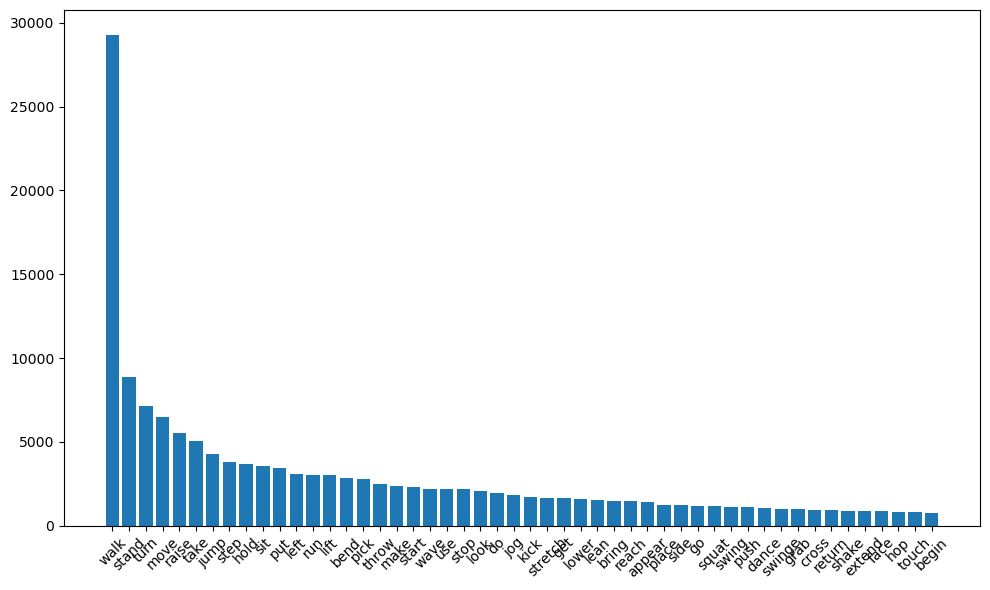

In [5]:
# 시각화
verbs, counts = zip(*top_verbs)
plt.figure(figsize=(10, 6))
plt.bar(verbs, counts)
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [10]:
target_word = 'moonwalk'
target_word2 = 'moonwalking'
target_word3 = 'moonwalks'

target_count = word_counter[target_word]
target_count2 = word_counter[target_word2]
target_count3 = word_counter[target_word3]

In [11]:
print(f"'{target_word}'의 개수: {target_count}")
print(f"'{target_word2}'의 개수: {target_count2}")
print(f"'{target_word3}'의 개수: {target_count3}")
print(f"'{target_word}'의 개수: {target_count + target_count2 + target_count3}")

'moonwalk'의 개수: 12
'moonwalking'의 개수: 0
'moonwalks'의 개수: 0
'moonwalk'의 개수: 12


## 2. HumanML3D <-> AMASS mapping

In [ ]:
'''
1. json파일을 불러온다(딕셔너리로)
2. 불러온 json에서 'walking straight'로 검색 돌렸을 때 나오는 키를 반환
3. 인덱스.csv를 들고와서 newname과 일치하는 행을 검색
4. 일치행 찾았을 때, 소스패스를 반환 후 루트 패스랑 결합해서 리스트로 저장
5. 해당 파일들을 복사
6. mkdir 걷기동작 폴더 후 목적지 폴더에 복사
'''

In [2]:
# 텍스트 설명 하나로 합친 파일 불러오기(합치는 스크립트 따로 있음 - script/mergetext.ipynb)
file_path = "text_annotation.json"
with open(file_path, 'r') as json_file:
    data = json.load(json_file)

print(len(data))

29242


In [3]:
###############################################
search_term = "walk" # 검색어
###############################################

destination_folder = 'npz_keyword_sort/jump_npz' # 직접 설정하기

matching_keys = [key for key, value in data.items() if search_term in value]
for i in range(0,len(matching_keys)):
    matching_keys[i] = matching_keys[i].replace('txt','npy')
# print("Keys with values containing the word 'walking':", matching_keys[:92])
print(len(matching_keys))
result_motion_list = matching_keys
print(len(result_motion_list))
# print(result_motion_list)

11240
11240


In [4]:
'''
source_path: 원래 AMASS 데이터셋의 파일 경로(여기를 참조해서 파일을 사용함)
start_frame: 슬라이스했을 때 시작 프레임
end_frame: 슬라이스 했을 때 끝 프레임
new_name: HumanML3D 데이터 셋으로 바뀌었을 때의 파일 번호

***TO KNOW***
source_path에서는 끝이 .npy로 끝나는데 실제 폴더 경로 찾아가보면 .npz파일로 구성되어있음. 따라서 이걸 참조해서 복사할 경우 .npy를 .npz로 변환하는 과정을 한번 거쳐줘야함.
'''
df = pd.read_csv('index.csv')
df.head()

,source_path,start_frame,end_frame,new_name
0,./pose_data/KIT/3/kick_high_left02_poses.npy,0,117,000000.npy
1,./pose_data/humanact12/humanact12/P11G01R02F18...,0,-1,000001.npy
2,./pose_data/KIT/3/jump_left02_poses.npy,0,83,000002.npy
3,./pose_data/KIT/1747/displace_from_left_to_rig...,0,91,000003.npy
4,./pose_data/CMU/80/80_63_poses.npy,516,716,000004.npy


In [5]:
for i in range(0,len(df['source_path']) ):
    df['source_path'][i] = df['source_path'][i][2:]
    # print(df['source_path'][0])

In [6]:
# 테스트용 스크립트
matching_path = df.loc[df['new_name'] == result_motion_list[0], 'source_path']
print(matching_path.to_string(index=False))

pose_data/KIT/3/bend_right05_poses.npy


In [7]:
source_path_list = []
for i in range(0,len(result_motion_list)//2):
    matching_path = df.loc[df['new_name'] == result_motion_list[i], 'source_path'].tolist()
    print(i, matching_path)
    
    if(len(matching_path[0])>3): # 빈 리스트 추가 하지 않기
        source_path_list.append(matching_path[0])

0 ['pose_data/KIT/3/bend_right05_poses.npy']
1 ['pose_data/Eyes_Japan_Dataset/hamada/pose-06-hangon-hamada_poses.npy']
2 ['pose_data/KIT/9/step_over_gap05_poses.npy']
3 ['pose_data/KIT/378/push_recovery_stand_left03_poses.npy']
4 ['pose_data/CMU/36/36_15_poses.npy']
5 ['pose_data/TotalCapture/s3/walking2_poses.npy']
6 ['pose_data/EKUT/300/PushBK_25_poses.npy']
7 ['pose_data/KIT/4/WalkInCounterClockwiseCircle02_poses.npy']
8 ['pose_data/KIT/359/turn_right06_poses.npy']
9 ['pose_data/KIT/314/step_over_gap06_poses.npy']
10 ['pose_data/CMU/139/139_33_poses.npy']
11 ['pose_data/Transitions_mocap/mazen_c3d/punchkarate_jumpingtwist360_poses.npy']
12 ['pose_data/KIT/11/WalkingStraightBackwards09_1_poses.npy']
13 ['pose_data/MPI_HDM05/dg/HDM_dg_06-02_01_120_poses.npy']
14 ['pose_data/BMLmovi/Subject_9_F_MoSh/Subject_9_F_5_poses.npy']
15 ['pose_data/Eyes_Japan_Dataset/aita/turn-03-look at-aita_poses.npy']
16 ['pose_data/ACCAD/Female1Running_c3d/C19 -  run to hop to walk_poses.npy']
17 ['pose_dat

In [ ]:
#npy로 되어있는거 npz로 바꾸기
for i in range(0,len(source_path_list)):
    # print(pathname)
    source_path_list[i] = source_path_list[i].replace('npy', 'npz')
    # source_path_list[i] = source_path_list[i].replace('/', "\\")

    # print(source_path_list[i])
print(source_path_list)

In [ ]:
# source_folder = '/path/to/source/folder'

#목적지 폴더 세팅하고 한번에 해당 파일 복사해서 저장하기
for full_file_path in source_path_list:
    file_name = full_file_path.split('/')[-1]
    file_base_name = file_name.split('.')[0][:-6]  # 확장자를 제외한 파일 이름 + '_poses' 없애기
    # print(file_base_name)
    source_path = full_file_path
    destination_path = os.path.join(destination_folder, file_name)
    # 경로 출력 (디버깅용)
    # print(f"Source Path: {source_path}")
    # print(f"Destination Path: {destination_path}")

    # 패턴 매칭을 통해 실제 파일 찾기
    search_pattern = f"{file_base_name}*"
    matching_files = glob.glob(os.path.join(os.path.dirname(full_file_path), search_pattern))
    

    if matching_files:
        # 매칭된 첫 번째 파일을 사용
        actual_file_path = matching_files[0]
        destination_path = os.path.join(destination_folder, os.path.basename(actual_file_path))

        # 파일 복사
        print(f"복사를 시작합니다: {actual_file_path} -> {destination_path}")
        shutil.copy(actual_file_path, destination_path)
        print(f"Copied {actual_file_path} to {destination_path}")
    else:
        print(f"File not found for pattern: {search_pattern}")

In [ ]:
# 테스트 스크립트

current_directory = os.getcwd()
print(current_directory)
items = os.listdir(current_directory)
print(items)

# 디렉토리인 항목만 필터링하여 출력
directories = [item for item in items if os.path.isdir(os.path.join(current_directory, item))]

# 결과 출력
print("Directories in the current working directory:")
for directory in directories:
    print(directory)

In [6]:
# ZIP 파일에서 모든 텍스트 수집 (JSON 형태로)
all_texts = {}

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if not file_name.endswith('.txt'):
            continue
            
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        
        # 각 파일의 모든 텍스트 라인을 하나로 합치기
        all_lines = []
        for line in text.splitlines():
            if line.strip():  # 빈 줄 제외
                all_lines.append(line.strip())
        
        # 파일명을 키로, 합쳐진 텍스트를 값으로 저장
        all_texts[file_name] = ' '.join(all_lines)

print(f"총 텍스트 파일 개수: {len(all_texts)}")
print(f"첫 번째 파일 예시:")
first_key = list(all_texts.keys())[0]
print(f"파일명: {first_key}")
print(f"내용: {all_texts[first_key][:200]}...")

총 텍스트 파일 개수: 29242
첫 번째 파일 예시:
파일명: 000000.txt
내용: a man kicks something or someone with his left leg.#a/DET man/NOUN kick/VERB something/PRON or/CCONJ someone/PRON with/ADP his/DET left/ADJ leg/NOUN#0.0#0.0 the standing person kicks with their left f...


In [ ]:
# 특정 단어들 검색 (ZIP 파일에서 직접) - 개선 버전
search_word1 = "walk"
search_word2 = "left"

matching_files = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if not file_name.endswith('.txt'):
            continue
            
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        
        # 전체 텍스트를 소문자로 변환하여 검색
        full_text = text.lower()
        
        # 두 단어가 모두 포함된 경우만 (AND 조건)
        if search_word1.lower() in full_text and search_word2.lower() in full_text:
            matching_files.append({
                'filename': file_name,
                'content': text.strip()
            })

print(f"'{search_word1}'와 '{search_word2}'를 모두 포함하는 파일 개수: {len(matching_files)}")

# 검증을 위한 추가 정보
print(f"\n검증:")
print(f"- '{search_word1}' 단독 포함 파일 확인 중...")
count_word1_only = 0
count_word2_only = 0

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if not file_name.endswith('.txt'):
            continue
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        full_text = text.lower()
        
        if search_word1.lower() in full_text:
            count_word1_only += 1
        if search_word2.lower() in full_text:
            count_word2_only += 1

print(f"- '{search_word1}' 포함 파일 총 개수: {count_word1_only}")
print(f"- '{search_word2}' 포함 파일 총 개수: {count_word2_only}")
print(f"- 둘 다 포함하는 파일 개수: {len(matching_files)}")

print("\n매칭된 파일들:")
for i, match in enumerate(matching_files[:10]):  # 상위 10개만 출력
    print(f"{i+1}. {match['filename']}")
    print(f"   내용: {match['content'][:100]}...")
    print()

'walk'와 'right'를 모두 포함하는 파일 개수: 4119

검증:
- 'walk' 단독 포함 파일 확인 중...
- 'walk' 포함 파일 총 개수: 11240
- 'right' 포함 파일 총 개수: 12385
- 둘 다 포함하는 파일 개수: 4119

매칭된 파일들:
1. 000005.txt
   내용: a person walks slowly forward then toward the left hand side and stands facing that direction.#a/DET...

2. 000006.txt
   내용: a person walks toward the front, turns to the right, bounces into a squat , and places both arms in ...

3. 000012.txt
   내용: a man stumbles to his right. the motion seems surprised so he was probably pushed.#a/DET man/NOUN st...

4. 000022.txt
   내용: a person walks forward then turns around and walks back.#a/DET person/NOUN walk/VERB forward/ADV the...

5. 000026.txt
   내용: a person paces back and forth in a small space#a/DET person/NOUN pace/VERB back/ADV and/CCONJ forth/...

6. 000027.txt
   내용: a person punches with their right hand before they do a counterclockwise spin.#a/DET person/NOUN pun...

7. 000040.txt
   내용: a person puts his hands together and bows, then it takes a step to 

In [5]:
import zipfile
import re

# ZIP 파일 경로 설정
zip_path = 'C:/Users/Velab/Desktop/HumanML3D_Org/texts.zip'

# 검색할 단어들 (walk의 다양한 형태)
#search_words = ["walk", "walking", "walks"]
search_words = ["slow", "slowly"]

# walk 관련 단어가 포함된 파일 찾기
matching_files = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        # .txt 파일만 처리
        if not file_name.endswith('.txt'):
            continue
            
        with zip_ref.open(file_name) as f:
            try:
                text = f.read().decode('utf-8')
            except UnicodeDecodeError:
                text = f.read().decode('latin-1')
        
        # 텍스트를 소문자로 변환하여 검색
        text_lower = text.lower()
        
        # 검색 단어 중 하나라도 포함되어 있는지 확인
        if any(word.lower() in text_lower for word in search_words):
            # 파일명에서 HumanML3D 번호 추출 (예: 000001.txt -> 000001)
            humanml_number = file_name.replace('.txt', '').split('/')[-1]
            matching_files.append({
                'filename': file_name,
                'humanml_id': humanml_number
            })

# 결과 출력
print(f"walk 관련 단어가 포함된 파일 개수: {len(matching_files)}")
print(f"\nHumanML3D 번호 목록:")
for i, item in enumerate(matching_files[:50], 1):  # 처음 50개만 출력
    print(f"{i}. {item['humanml_id']} (파일: {item['filename']})")

if len(matching_files) > 50:
    print(f"\n... 외 {len(matching_files) - 50}개 더 있음")

# HumanML3D 번호만 리스트로 추출
humanml_ids = [item['humanml_id'] for item in matching_files]
print(f"\n총 {len(humanml_ids)}개의 HumanML3D 모션 데이터")

walk 관련 단어가 포함된 파일 개수: 3470

HumanML3D 번호 목록:
1. 000005 (파일: 000005.txt)
2. 000014 (파일: 000014.txt)
3. 000023 (파일: 000023.txt)
4. 000026 (파일: 000026.txt)
5. 000028 (파일: 000028.txt)
6. 000057 (파일: 000057.txt)
7. 000061 (파일: 000061.txt)
8. 000075 (파일: 000075.txt)
9. 000083 (파일: 000083.txt)
10. 000095 (파일: 000095.txt)
11. 000107 (파일: 000107.txt)
12. 000112 (파일: 000112.txt)
13. 000118 (파일: 000118.txt)
14. 000128 (파일: 000128.txt)
15. 000130 (파일: 000130.txt)
16. 000132 (파일: 000132.txt)
17. 000139 (파일: 000139.txt)
18. 000144 (파일: 000144.txt)
19. 000175 (파일: 000175.txt)
20. 000209 (파일: 000209.txt)
21. 000211 (파일: 000211.txt)
22. 000212 (파일: 000212.txt)
23. 000228 (파일: 000228.txt)
24. 000229 (파일: 000229.txt)
25. 000231 (파일: 000231.txt)
26. 000232 (파일: 000232.txt)
27. 000237 (파일: 000237.txt)
28. 000246 (파일: 000246.txt)
29. 000248 (파일: 000248.txt)
30. 000256 (파일: 000256.txt)
31. 000257 (파일: 000257.txt)
32. 000261 (파일: 000261.txt)
33. 000273 (파일: 000273.txt)
34. 000304 (파일: 000304.txt)
35. 000311 